# Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os, json, re, sys
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_path = r'your_path'
production_path = r'your_path'

In [3]:
def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)

In [4]:
train = fetch_data(train_path)
test = fetch_data(production_path)

In [5]:
train.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [6]:
grouped_train = train.groupby(by='invoice_date').aggregate({'price':'sum','times_viewed':'sum'}).reset_index()
grouped_test = test.groupby(by='invoice_date').aggregate({'price':'sum','times_viewed':'sum'}).reset_index()
grouped_train.set_index('invoice_date',inplace=True)
grouped_test.set_index('invoice_date',inplace=True)
grouped_train.head()

,price,times_viewed
invoice_date,,
2017-11-28,14450.54,15047
2017-11-29,13411.96,14159
2017-11-30,13290.25,15766
2017-12-01,9687.28,12524
2017-12-02,1443.26,3313


(array([17471., 17532., 17591., 17652., 17713., 17775., 17836., 17897.,
        17956., 18017., 18078.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

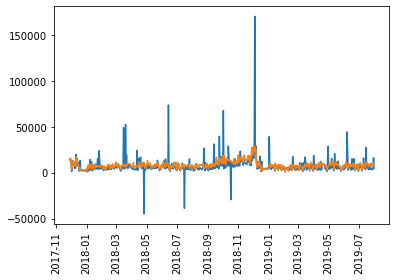

In [7]:
plt.plot(grouped_train)
plt.xticks(rotation=90)

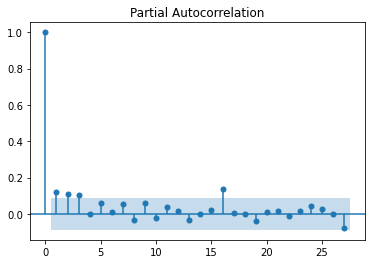

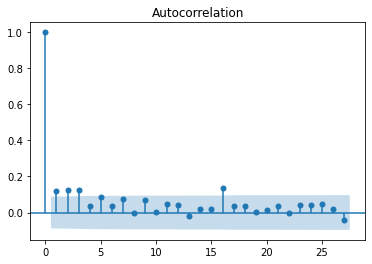

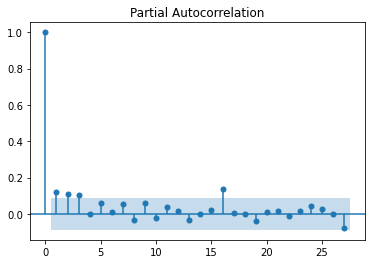

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(grouped_train['price'])
plot_pacf(grouped_train['price'])

In [9]:
model = ARIMA(grouped_train['price'], order=(1,1,1))
results = model.fit()

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  494
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5293.300
Method:                       css-mle   S.D. of innovations          10872.792
Date:                Mon, 19 Apr 2021   AIC                          10594.601
Time:                        09:12:17   BIC                          10611.411
Sample:                             1   HQIC                         10601.200
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.7799     27.419     -0.138      0.890     -57.521      49.961
ar.L1.D.price     0.0656      0.051      1.281      0.200      -0.035       0.166
ma.L1.D.price    -0.9498      0.024    -

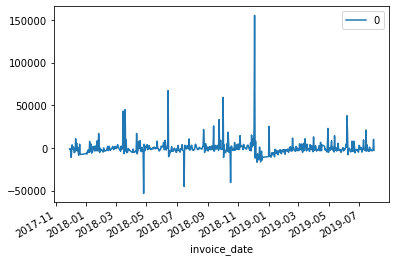

In [10]:
print(results.summary())
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.show()

predicted=6775.472577, expected=6477.520000
predicted=6971.086990, expected=4666.740000
predicted=5900.796672, expected=1310.750000
predicted=6259.484667, expected=8444.060000
predicted=6395.219293, expected=4280.670000
predicted=5006.817640, expected=6398.080000
predicted=5574.042227, expected=14197.550000
predicted=6723.218149, expected=-6946.440000
predicted=4662.028950, expected=2148.460000
predicted=4124.647195, expected=2759.840000
predicted=2510.312882, expected=3041.850000
predicted=4201.967154, expected=8401.740000
predicted=3643.992354, expected=4655.230000
predicted=3034.920088, expected=2273.590000
predicted=4053.421674, expected=3326.300000
predicted=3653.917703, expected=3599.880000
predicted=4092.105783, expected=4402.640000
predicted=4324.203565, expected=18434.440000
predicted=6772.282147, expected=5540.050000
predicted=6976.557938, expected=2623.570000
predicted=6700.294750, expected=2839.430000
predicted=5032.295952, expected=15682.570000
predicted=8649.877231, expec

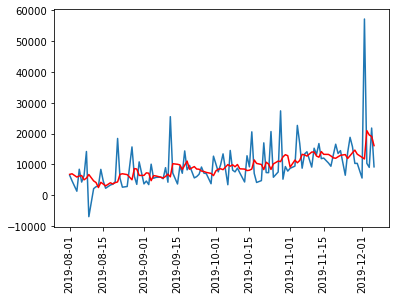

In [16]:
history = [x for x in grouped_train['price']]
predictions = list()
# walk-forward validation
for t in range(len(grouped_test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = grouped_test['price'][t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(grouped_test['price'], predictions))
print('Test RMSE: %.3f' % rmse)
grouped_test['predictions'] = predictions
# plot forecasts against actual outcomes
plt.plot(grouped_test['price'])
plt.plot(grouped_test['predictions'], color='red')
plt.xticks(rotation=90)
plt.show()

In [44]:
%%writefile Dockerfile

# Use an official Python runtime as a parent image
# FROM python:3.8-slim-buster
# FROM python:3.7.5-stretch
FROM python:3.9

RUN apt-get update && apt-get install -y \
python3-dev \
build-essential    
        
# Set the working directory to /app
WORKDIR /app

# Copy the current directory contents into the container at /app
ADD . /app

# Install any needed packages specified in requirements.txt
RUN pip install --upgrade pip
RUN pip install --no-cache-dir -r requirements.txt

# Make port 80 available to the world outside this container
EXPOSE 80

# Define environment variable
ENV NAME World

# Run app.py when the container launches
CMD ["python", "app.py"]

Overwriting Dockerfile
